In [35]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from plot_functions import adjustAxeProperties
%matplotlib inline
matplotlib.style.use('ggplot')

In [37]:
def plot_history(history):
    FONTSIZE = 23
    plt.close('all')
    fig = plt.figure(figsize=(18, 7.5))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    epochs = range(1, len(history.history['loss']) + 1)

    # plot loss function
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax = plt.subplot(gs[0, 0])
    ax.plot(epochs, train_loss, marker='o', label='training loss')
    ax.plot(epochs, val_loss, marker='x', label='validation loss')
    ax.set_xlabel('epoch', fontsize=FONTSIZE, labelpad=15)
    ax.set_ylabel('Loss', fontsize=FONTSIZE, labelpad=15)
    ax.set_ylim(0)
    ax.set_xticks(np.arange(1, len(epochs)+1, 3))
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
    ax.legend(loc='best', fontsize=FONTSIZE*0.85)
    ax.set_title('Loss fucntion', fontsize=FONTSIZE)


    # plot acuracy
    train_acuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    ax = plt.subplot(gs[0, 1])
    ax.plot(epochs, train_acuracy, marker='o', label='training acc.')
    ax.plot(epochs, val_accuracy, marker='x', label='validation acc.')
    ax.set_xlabel('epoch', fontsize=FONTSIZE, labelpad=15)
    ax.set_ylabel('Accuracy', fontsize=FONTSIZE, labelpad=15)
    ax.set_ylim(0, 1.05)    
    ax.set_xticks(np.arange(1, len(epochs)+1, 3))
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)    
    ax.legend(loc='best', fontsize=FONTSIZE*0.85)
    ax.set_title('Accuracy', fontsize=FONTSIZE)

    plt.tight_layout(w_pad=3.0, h_pad=1)

In [2]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [6]:
import keras as k
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [9]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [10]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
base_dir = os.path.expanduser('~/ml_datasets/cats_and_dogs_small')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Use features extraction without data augmentation

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [26]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for (inputs_batch, labels_batch) in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [27]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


In [31]:
model = k.models.Sequential()
model.add(k.layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=k.optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [38]:
history = model.fit(
    train_features, 
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0857 - acc: 0.9730 - val_loss: 0.2403 - val_acc: 0.9030
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0826 - acc: 0.9770 - val_loss: 0.2435 - val_acc: 0.9000
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0779 - acc: 0.9795 - val_loss: 0.2416 - val_acc: 0.9010
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0736 - acc: 0.9775 - val_loss: 0.2456 - val_acc: 0.9000
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0773 - acc: 0.9775 - val_loss: 0.2420 - val_acc: 0.9010
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0720 - acc: 0.9810 - val_loss: 0.2417 - val_acc: 0.9010
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0677 - acc: 0.9860 - val_loss: 0.2471 - val_acc: 0.9020
Epoch 8/30
200

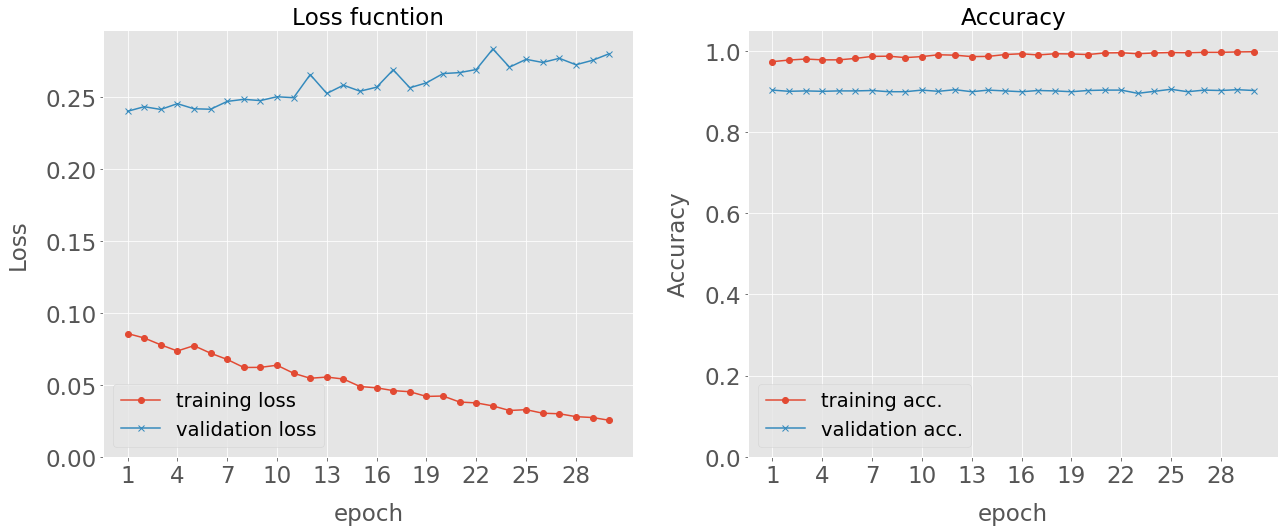

In [39]:
plot_history(history)

### Use features extraction with data augmentation

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [48]:
model = k.models.Sequential()
model.add(conv_base)
model.add(k.layers.Flatten())
model.add(k.layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(k.layers.Dense(1, activation='sigmoid'))

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.trainable_weights

[<tf.Variable 'block1_conv1_1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv1_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block1_conv2_1/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv2_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block2_conv1_1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv1_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block2_conv2_1/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv2_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block3_conv1_1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv1_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv2_1/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv2_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv3_1/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 

In [51]:
conv_base.trainable = False

In [52]:
model.trainable_weights

[<tf.Variable 'dense_10/kernel:0' shape=(8192, 256) dtype=float32_ref>,
 <tf.Variable 'dense_10/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_11/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'dense_11/bias:0' shape=(1,) dtype=float32_ref>]

In [54]:
model.compile(
    optimizer=k.optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [55]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 522s 5s/step - loss: 0.5949 - acc: 0.6940 - val_loss: 0.4533 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 561s 6s/step - loss: 0.4868 - acc: 0.7760 - val_loss: 0.3746 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 571s 6s/step - loss: 0.4412 - acc: 0.8090 - val_loss: 0.3356 - val_acc: 0.8770
Epoch 4/30
100/100 [==============================] - 571s 6s/step - loss: 0.4071 - acc: 0.8170 - val_loss: 0.3119 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 601s 6s/step - loss: 0.3794 - acc: 0.8315 - val_loss: 0.2900 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 571s 6s/step - loss: 0.3736 - acc: 0.8385 - val_loss: 0.2777 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 573s 6s/step - loss: 0.3563 - acc: 0.8420 - val_loss: 0.2723 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 552s 6s/step - 

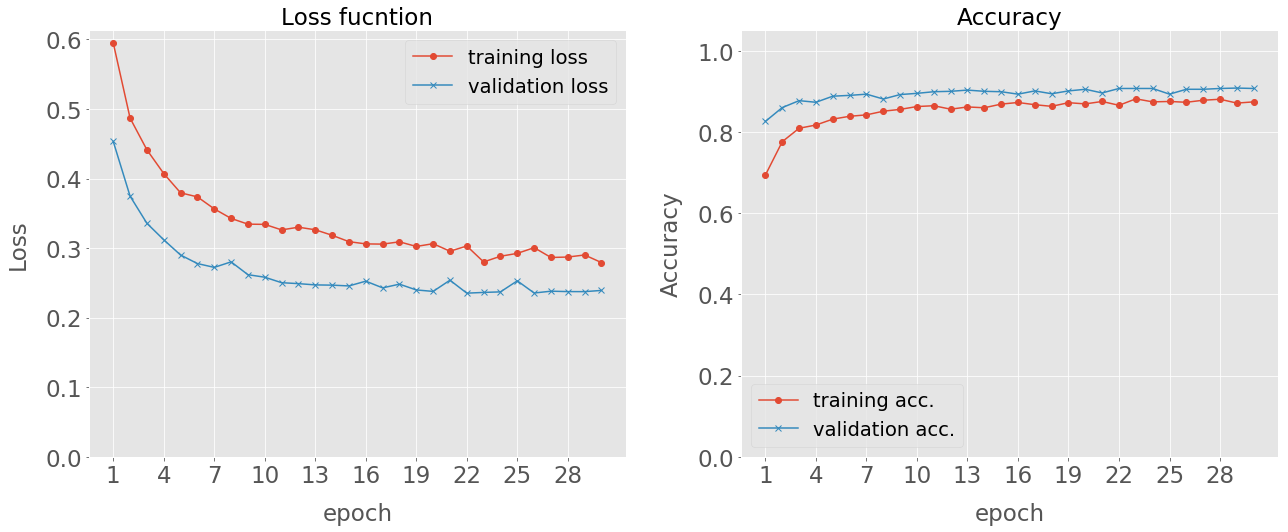

In [56]:
plot_history(history)